# Discriminative Sparse Coding

### import libraries

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import time
import librosa
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import SparseCoder,DictionaryLearning
from sklearn import cluster
# from lightning.regression import CDRegressor
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

In [2]:
class DDSC():
    def __init__(self, train_set, train_sum, alpha, 
                 epsilon, reg_lambda, steps, n, m, T, k):
        """
        Inputs:
            train_set: dict of X_i matrix with dim T*m for each individual appliance i 
            train_sum: dataframe of X_sum aggregated matrix T*m 
            alpha: gradiant rate for the convergence step for DD (4b).
            epsilon: gradient stepsize of the pre-training (2e) ||A_t+1 - A_t||< epsilon 
            reg_lambda: reguarization weight of penalty function
            steps: interations to be performed for the convergence part
            n: number of basis functions 
            m: number of features (households)
            T: number of samples (hours)
            k: number of applicances i (1, k)
        """
        self.train_set = train_set.values()
        self.train_sum = train_sum.values
        self.alpha = alpha 
        self.epsilon = epsilon
        self.reg_lambda = reg_lambda
        self.steps = steps
        self.n = n 
        self.m = m
        self.T = T
        self.k = k
        
        # ======= Instances that can be used for plotting =====
        self.acc_nnsc = None
        self.err_nnsc = None
        self.acc_ddsc = None
        self.err_ddsc = None
        
        self.a_nnsc = None
        self.b_nnsc = None
        self.a_ddsc = None
        self.b_ddsc = None

    def _initialization(self):
        '''
        DDSC step 1
        initiualize the matrices A,B with positive values
        scale columns of B s.t b(j) = 1
        '''
        A = np.random.random((self.n,self.m)) # A: n*m
        B = np.random.random((self.T,self.n)) # B: T*n

        # scale columns s.t. b_i^(j) = 1
        B /= sum(B) 
        
        return A, B
    
    @staticmethod
    def _pos_constraint(mat):
        '''
        nnsc step 2(b)
        using only the positive values of matrix  
        input: matrix n*m 
        '''     
        indices = np.where(mat < 0.0)
        mat[indices] = 0.0
        return mat   
    
    def nnsc(self):
        '''
        Method as in NNSC from nonnegative sparse coding finland.
        from P.Hoyer

        return:
            A_list, B_list: list of A and B for each appliance i 
        '''
        
        acc_nnsc = []
        err_nnsc = []
        a_nnsc = []
        b_nnsc = []
        
        # used for F
        X_train = self.train_set # dict_value 
        A_list = []
        B_list = []
        
        for X in X_train:
            # step 1 
            A0, B0 = self._initialization() # initialization 
            Ap, Bp = A0, B0 
            Ap1, Bp1 = Ap, Bp # record previous step Ap, Bp
            t = 0
            change_A = 1.0
            while t <= self.steps and change_A >= self.epsilon:            
                Bp = Bp - self.alpha * np.dot((np.dot(Bp, Ap) - X), Ap.T) # step 2a
                Bp = self._pos_constraint(Bp) # step 2b 
                Bp /= sum(Bp) # step 2c 
                
                # step 2d
                dot_part2 = np.divide(np.dot(Bp.T, X), (np.dot(np.dot(Bp.T, Bp), Ap) + self.reg_lambda)) # element wise division 
                Ap = np.multiply(Ap, dot_part2)

                change_A = np.linalg.norm(Ap - Ap1)
                change_B = np.linalg.norm(Bp - Bp1)
                Ap1, Bp1 = Ap, Bp
                t += 1
                
                if t % 10 == 0:
                    print("iter {t}：A change = {a:8.4f}".format(t=t, a=change_A))
                
            print("Gone through one appliance.\n")
            A_list.append(Ap)
            B_list.append(Bp)


        # for thesis
        acc_iter = self.accuracy(X_train, self.train_sum, B_list, A_list)
        err_iter = self.error(X_train, self.train_sum, B_list, A_list)
        acc_nnsc.append(acc_iter)
        err_nnsc.append(err_iter)
        # append norm of matrices
        a_nnsc.append(np.linalg.norm(sum(A_list)))
        b_nnsc.append(np.linalg.norm(sum(B_list)))

        self.acc_nnsc = acc_nnsc
        self.err_nnsc = err_nnsc
        self.a_nnsc = a_nnsc
        self.b_nnsc = b_nnsc
        
        return A_list, B_list

    def accuracy(self, X_train, X_sum, B, A):
        '''
        inputs:
            X_train: dict_value of list 
        
        Everything needs to be in lists of ndarrays
        of the components
        '''
        B_cat = np.hstack(B)
        A_cat = np.vstack(A)

        A_prime = self.F(X_sum, B_cat, A=A_cat)
        A_last = np.split(A_prime, self.k, axis=0)
        X_predict = self.predict(A_last, B)
        
        
        X_train = list(X_train)
        

        acc_numerator = [np.sum(np.minimum((B[i].dot(A_last[i])).sum(axis=0), (sum(X_train[i].sum(axis=0)))))
                         for i in range(len(B))]
        
        
        acc_denominator = sum(X_predict).sum()
        acc = sum(acc_numerator) / acc_denominator
        
        acc_denominator = X_sum.sum()
        acc_star = sum(acc_numerator) / acc_denominator
        return acc, acc_star

    def get_accuracy_plot(self):
        return self.acc_nnsc, self.acc_ddsc

    def get_error_plot(self):
        return self.err_nnsc, self.err_ddsc

    def get_a(self):
        return self.a_nnsc, self.a_ddsc

    def get_b(self):
        return self.b_nnsc, self.b_ddsc

    def error(self,X, X_sum, B, A):
        '''
        Error for the whole disaggregation part within list, sum the list to get
        the resulting disaggregation
        Parameters : must have x_train as x
        '''
        B_cat = np.hstack(B)
        A_cat = np.vstack(A)
        
        
        error = [(1.0/2.0) * np.linalg.norm((list(X)[i] - B[i].dot(A[i]))**2) for i in range(self.k)]
        error = sum(error)
        
        A_last_error = self.F(X_sum, B_cat,A_cat)
        
        A_last_error_list = np.split(A_last_error,self.k,axis=0)
        error_star = [(1.0/2.0) * np.linalg.norm((list(X)[i] - B[i].dot(A_last_error_list[i]))**2) for i in range(self.k)]
        error_star = sum(error_star)
        return error, error_star
        
    
    def F(self, X_sum, B, A):
        '''
        input is lists of the elements
        output list of elements
        '''
        # 4a  
        B = np.asarray(B)
        A = np.asarray(A)
        
        coder = SparseCoder(dictionary=B.T, transform_alpha=self.reg_lambda, transform_algorithm='lasso_cd')    
        # B: basis function 
        # A: activation function   
        B_hat, A_hat = librosa.decompose.decompose(X_sum, transformer=coder) 
        A_hat = self._pos_constraint(A_hat)

        return A_hat

    def DD(self, B, A):
        '''
        Taking the parameters as x_train_use and discriminate over the
        entire region
        '''
        # step 3
        A_star = np.vstack(A)
        B_cat = np.hstack(B)
        
        # step 4 
        change_B = 1 
        t = 0
        
        acc_ddsc = []
        err_ddsc = []
        a_ddsc = []
        b_ddsc = []
        
        X_sum = self.train_sum # change df to list of list   
        X_train = self.train_set
        
        while t <= self.steps and self.epsilon <= change_B:
            B_cat_p = B_cat
            
            # step 4a
            A_hat = self.F(X_sum, B_cat, A_star)
            
            # step 4b
            B_cat = (B_cat - self.alpha * ((X_sum - B_cat.dot(A_hat)).dot(A_hat.T) - (X_sum - B_cat.dot(A_star)).dot(A_star.T)))
            
            # step 4c
            B_cat = self._pos_constraint(B_cat) # scale columns s.t. b_i^(j) = 1
            B_cat /= sum(B_cat)
            
            change_B = np.linalg.norm(B_cat - B_cat_p)
            t += 1
            
    
            print("step {t}: B change = {c:.4f}".format(t=t, c=change_B))

            # convergence check
            A_hat_split = np.split(A_hat, self.k, axis=0)
            B_split = np.split(B_cat,self.k,axis=1)
            
            acc_iter = self.accuracy(X_train, X_sum, B, A_hat_split)
            acc_iter = self.accuracy(X_train, X_sum, B_split, A)
            err_iter = self.error(X_train, X_sum, B, A_hat_split)

#             error, error_star = sc.error(list(x_train.values()),train_sum,B_list,A_list)

               
            acc_ddsc.append(acc_iter)
            err_ddsc.append(err_iter)
            a_ddsc.append(np.linalg.norm(A_hat))
            b_ddsc.append(np.linalg.norm(B_cat))

        self.acc_ddsc = acc_ddsc
        self.err_ddsc = err_ddsc
        self.a_ddsc = a_ddsc
        self.b_ddsc = b_ddsc
        return B_cat

    def predict(self, A, B):
        result = [x.dot(y) for (x, y) in zip(B, A)]
        return result 

In [3]:
from dataprocess import read_data, format_data, split

df, houses = read_data()
df.head()

,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,
2242,2014-01-01 00:00:00,1.194,0.032,0.013,0.0,0.083,1.066
2242,2014-01-01 01:00:00,1.185,0.032,0.271,0.0,0.078,0.804
2242,2014-01-01 02:00:00,1.307,0.032,0.305,0.0,0.087,0.883
2242,2014-01-01 03:00:00,1.515,0.031,0.648,0.0,0.109,0.727
2242,2014-01-01 04:00:00,1.175,0.032,0.408,0.0,0.092,0.643


In [4]:
d = format_data(df, houses)

In [5]:
timeframe = 336
portion = 0.5

x_train, x_test = split(d, portion, timeframe)
x_train_sum = x_train.pop('use',None) # aggregated 
x_test_sum = x_test.pop('use',None) 
x_train_localhour = x_train.pop('localhour',None)
x_test_localhour = x_test.pop('localhour',None)

k = len(x_train.keys())
T, m = x_train[list(x_train.keys())[0]].shape
reg_par = 0.0005
epsilon = 0.001
alpha = 0.001
n = 150
steps = 100 # steps must be higher than k


sc = DDSC(x_train, x_train_sum, alpha, epsilon, reg_par, steps, n, m, T, k)


print('pre-training: ')
A_list,B_list = sc.nnsc()

print('DD: ')
# Discriminative Disaggregation training
B_cat = sc.DD(B_list, A_list)


# Given test examples x_test
A_prime = sc.F(x_test_sum.values, B_cat, A=np.vstack(A_list))
A_last = np.split(A_prime,k,axis=0)

x_predict = sc.predict(A_last,B_list)

pre-training: 
iter 10：A change =   3.9849
iter 20：A change =   0.7306
iter 30：A change =   0.2781
iter 40：A change =   0.1592
iter 50：A change =   0.1039
iter 60：A change =   0.0748
iter 70：A change =   0.0571
iter 80：A change =   0.0452
iter 90：A change =   0.0369
iter 100：A change =   0.0308
Gone through one appliance.

iter 10：A change =   4.4623
iter 20：A change =   1.9060
iter 30：A change =   1.2409
iter 40：A change =   0.6273
iter 50：A change =   0.4012
iter 60：A change =   0.4322
iter 70：A change =   0.4267
iter 80：A change =   0.2880
iter 90：A change =   0.1970
iter 100：A change =   0.1555
Gone through one appliance.

iter 10：A change =   0.9347
iter 20：A change =   0.9441
iter 30：A change =   0.4859
iter 40：A change =   0.3561
iter 50：A change =   0.2052
iter 60：A change =   0.1539
iter 70：A change =   0.1238
iter 80：A change =   0.0980
iter 90：A change =   0.0778
iter 100：A change =   0.0632
Gone through one appliance.

iter 10：A change =   0.3698
iter 20：A change =   0.4029

In [6]:
print("the shape of the first predicted appliances is :%s" %(np.asarray(x_predict[1]).shape,))
x_predict_sum = sum(x_predict)

# energy disaggregation accuracy
acc = sc.accuracy(x_train.values(), x_train_sum, B_list, A_last)
# energy disaggregation error
error, error_star = sc.error(x_train.values(), x_train_sum, B_list, A_list)

print("error: %s, error_star: %s" % (error, error_star))
acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
err_nnsc, err_ddsc = sc.get_error_plot()
# plotting acc/err
a_nnsc, a_ddsc = sc.get_a()
b_nnsc, b_ddsc = sc.get_b()

the shape of the first predicted appliances is :(168, 21)
error: 9.69264056469866, error_star: 244.80816737870458


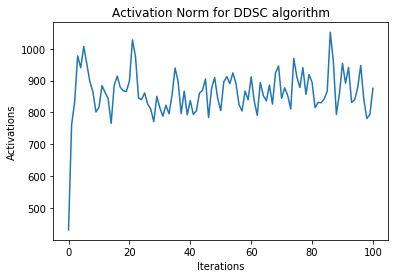

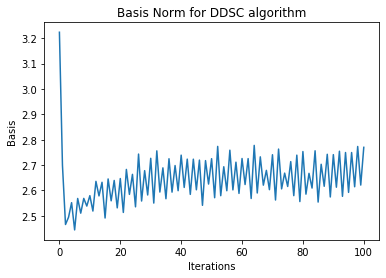

In [7]:
a_nnsc, a_ddsc = sc.get_a()
b_nnsc, b_ddsc = sc.get_b()
plt.plot(a_ddsc)
plt.ylabel('Activations')
plt.xlabel('Iterations')
plt.title('Activation Norm for DDSC algorithm')
plt.show()

plt.plot(b_ddsc)
plt.ylabel('Basis')
plt.xlabel('Iterations')
plt.title('Basis Norm for DDSC algorithm')
plt.show()

In [8]:
print("the shape of the first predicted appliances is :%s" %(np.asarray(list(x_predict)[1]).shape,))


the shape of the first predicted appliances is :(168, 21)


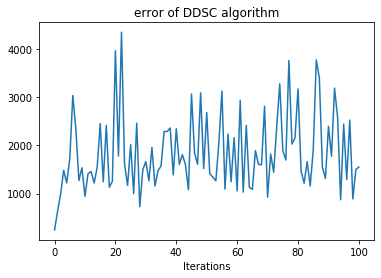

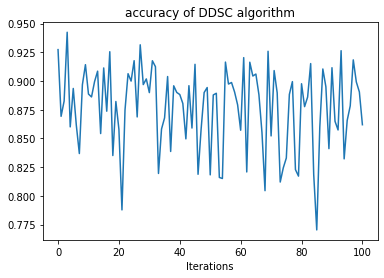

In [9]:
err_nnddsc, err_ddddsc = sc.get_error_plot()
res_err = list(zip(*err_ddddsc)) 
plt.plot(res_err[0])
plt.title('error of DDSC algorithm')
plt.xlabel('Iterations')
plt.show()

acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
res_acc = list(zip(*acc_ddsc)) 
plt.plot(res_acc[0])
plt.title('accuracy of DDSC algorithm')
plt.xlabel('Iterations')
plt.show()


In [10]:
x_predict = sc.predict(A_last,B_list)
print("the shape of the first predicted appliances is :%s" %(np.asarray(list(x_predict)[0]).shape,))

the shape of the first predicted appliances is :(168, 21)


In [ ]:
x_train.keys()

In [ ]:
#x_predict = sc.predict(A_last,B_list)
x_predict = sc.predict(A_list,B_list)

print(np.asarray(list(x_predict)[0])[0:,house])

Text(0.5, 0, 'Hours')

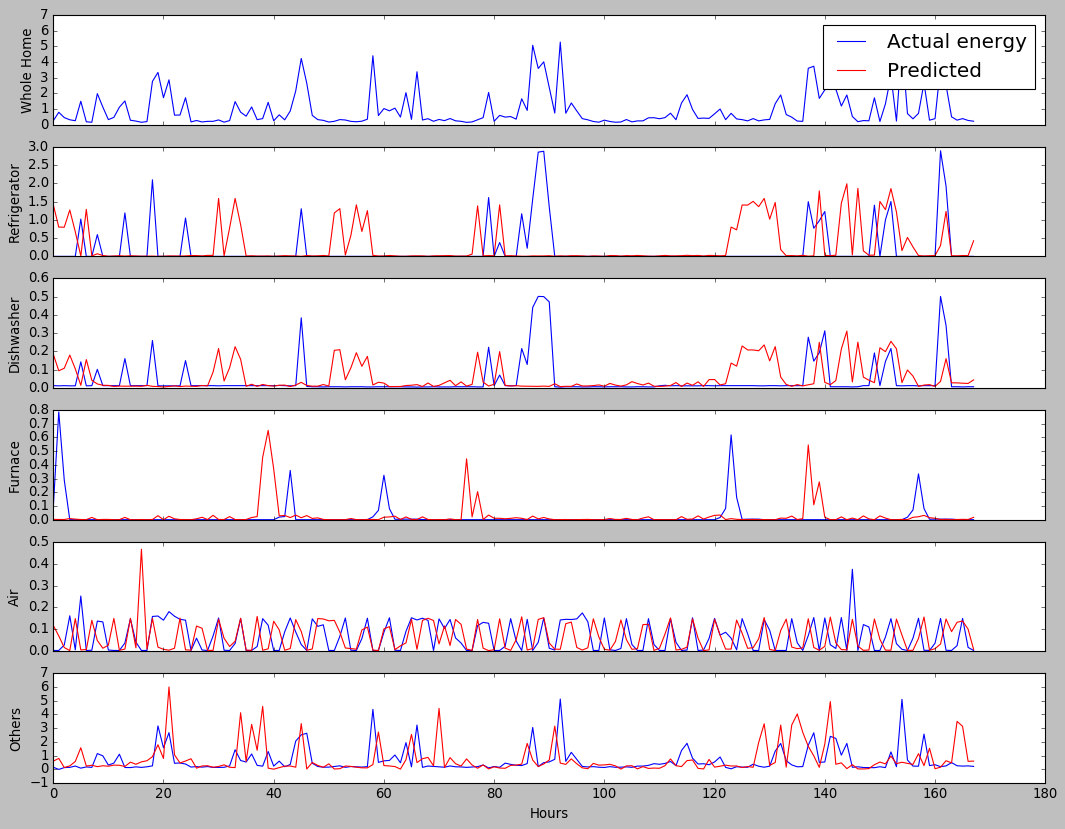

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('classic')
# row and column sharing
house = 6

pie_chart_true = []
pie_chart_pred = []

f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, sharex='col', sharey='row', figsize=(16,12))
x = range(x_train[list(x_train.keys())[0]].shape[0])
plt.rcParams.update({'font.size': 15})


#===========whole home============
y_use_true = np.asarray(x_test_sum)[0:,house]
ax1.plot(x, y_use_true, color='b',label='Actual energy')
y_use_pred = [-1]*x_train[list(x_train.keys())[0]].shape[0]
ax1.plot(x, y_use_pred, color='r', label='Predicted')
ax1.set_ylim([0,7])
ax1.set_ylabel('Whole Home')
ax1.legend()

#===========regrigerator============
y_ref_true = np.asarray(x_test[list(x_test.keys())[0]])[0:,house]
ax2.plot(x, y_ref_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_ref_pred = np.asarray(list(x_predict)[0])[0:,house]
ax2.plot(x, y_ref_pred, color='r')
#ax2.get_yaxis().set_visible(False)
ax2.set_ylabel('Refrigerator')



#===========dishwasher============
y_dish_true = np.asarray(x_test[list(x_test.keys())[1]])[0:,house]
ax3.plot(x, y_dish_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_dish_pred = np.asarray(list(x_predict)[1])[0:,house]
ax3.plot(x,y_dish_pred, color='r')
#ax3.get_yaxis().set_visible(False)
ax3.set_ylabel('Dishwasher')
#ax3.set_ylim(-0.00001)

#===========furnace============
y_fur_true = np.asarray(x_test[list(x_test.keys())[2]])[0:,house]
ax4.plot(x, y_fur_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_fur_pred = np.asarray(list(x_predict)[2])[0:,house]
ax4.plot(x,y_fur_pred, color='r')
#ax4.get_yaxis().set_visible(False)
ax4.set_ylabel('Furnace')
# ax4.set_ylim(-0.05, 0.05)

#===========Air============
y_air_true = np.asarray(x_test[list(x_test.keys())[3]])[0:,house]
ax5.plot(x, y_air_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_air_pred = np.asarray(list(x_predict)[3])[0:,house]
ax5.plot(x, y_air_pred, color='r')
#ax5.get_yaxis().set_visible(False)
ax5.set_ylabel('Air')
# ax5.set_xlabel('Hours')

#===========others============
y_other_true = np.asarray(x_test[list(x_test.keys())[4]])[0:,house]
ax6.plot(x, y_other_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_other_pred = np.asarray(list(x_predict)[4])[0:,house]
ax6.plot(x, y_other_pred, color='r')
#ax5.get_yaxis().set_visible(False)
ax6.set_ylabel('Others')
ax6.set_xlabel('Hours')

In [20]:
x = range(x_train[list(x_train.keys())[0]].shape[0])
y_air_true = np.asarray(x_test[list(x_test.keys())[3]])[0:,house]
y_air_pred = np.asarray(list(x_predict)[3])[0:,house]

result_df = pd.DataFrame({'actuals':y_air_true, 'predicted':y_air_pred})
result_df.head()



,actuals,predicted
0,0.004,0.118198
1,0.004,0.070499
2,0.029,0.017339
3,0.162,0.003582
4,0.007,0.149094


In [21]:
def detect_classify_anomalies(df,window):
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    df['load_date'] = pd.date_range(start='6/1/2014', periods=len(df), freq='H')
#     df = df.sort_values(by='load_date', ascending=False)
#     df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
    return df

df = detect_classify_anomalies(result_df, window=5)
df.head(10)


,actuals,predicted,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s,impact,color,region,anomaly_points,load_date
0,0.004,0.118198,-0.114198,-2854.950098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,-0.114198,2014-06-01 00:00:00
1,0.004,0.070499,-0.066499,-1662.483516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,-0.066499,2014-06-01 01:00:00
2,0.029,0.017339,0.011661,40.211982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,0.011661,2014-06-01 02:00:00
3,0.162,0.003582,0.158418,97.789028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,0.158418,2014-06-01 03:00:00
4,0.007,0.149094,-0.142094,-2029.919452,-0.030542,0.120646,-0.271835,0.210751,-0.241674,0.180589,-0.211512,0.150427,3,0,NEGATIVE,NaN,2014-06-01 04:00:00
5,0.252,0.006475,0.245525,97.430490,0.041402,0.159340,-0.277278,0.360082,-0.237443,0.320247,-0.197608,0.280412,4,0,POSITIVE,NaN,2014-06-01 05:00:00
6,0.004,0.008181,-0.004181,-104.513759,0.053866,0.151009,-0.248153,0.355885,-0.210401,0.318132,-0.172648,0.280380,3,0,NEGATIVE,NaN,2014-06-01 06:00:00
7,0.005,0.141337,-0.136337,-2726.739090,0.024266,0.174091,-0.323916,0.372448,-0.280393,0.328925,-0.236870,0.285403,3,0,NEGATIVE,NaN,2014-06-01 07:00:00
8,0.138,0.049272,0.088728,64.295744,0.010328,0.163109,-0.315889,0.336546,-0.275112,0.295768,-0.234335,0.254991,4,0,POSITIVE,NaN,2014-06-01 08:00:00
9,0.134,0.014252,0.119748,89.364369,0.062697,0.142693,-0.222690,0.348084,-0.187017,0.312410,-0.151343,0.276737,4,0,POSITIVE,NaN,2014-06-01 09:00:00


In [22]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib import pyplot

def plot_anomaly(df,metric_name):
    #error = pd.DataFrame(Order_results.error.values)
    #df = df.sort_values(by='load_date', ascending=False)
    #df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y%m%d")
    dates = df.load_date
    #meanval = error.rolling(window=window).mean()
    #deviation = error.rolling(window=window).std()
    #res = error
#upper_bond=meanval + (2 * deviation)
    #lower_bond=meanval - (2 * deviation)
#anomalies = pd.DataFrame(index=res.index, columns=res.columns)
    #anomalies[res < lower_bond] = res[res < lower_bond]
    #anomalies[res > upper_bond] = res[res > upper_bond]
    bool_array = (abs(df['anomaly_points']) > 0)
#And a subplot of the Actual Values.
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
#Order_results['meanval']=meanval
    #Order_results['deviation']=deviation
    color_map= {0: "palegreen", 1: "yellow", 2: "orange", 3: "red"}
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2 ],
    #columnorder=[0, 1, 2,],
    header = dict(height = 20,
                  values = [['<b>Date</b>'],['<b>Actual Values </b>'],
                            ['<b>Predicted</b>'], ['<b>% Difference</b>'],['<b>Severity (0-3)</b>']],
                 font = dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                  fill = dict(color='#d562be')),
    cells = dict(values = [df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'predicted',
                                                               'percentage_change','color']],
                 line = dict(color='#506784'),
                 align = ['center'] * 5,
                 font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                 #format = [None] + [",.4f"] + [',.4f'],
#suffix=[None] * 4,
                 suffix=[None] + [''] + [''] + ['%'] + [''],
                 height = 27,
                 #fill = dict(color=['rgb(235, 193, 238)', 'rgba(228, 222, 249, 0.65)']))
                 fill=dict(color=  # ['rgb(245,245,245)',#unique color for the first column
                      [df['color'].map(color_map)],
                      )
    ))
# df['ano'] = np.where(df['color']==3, df['error'], np.nan)
    anomalies = go.Scatter(name="Anomaly",
                       x=dates,
                       xaxis='x1',
                       yaxis='y1',
                       y=df['anomaly_points'],
                       mode='markers',
                       marker = dict(color ='red',
                      size = 11,line = dict(
                                         color = 'red',
                                         width = 2)))
    upper_bound = go.Scatter(hoverinfo="skip",
                         x=dates,
                         showlegend =False,
                         xaxis='x1',
                         yaxis='y1',
                         y=df['3s'],
                         marker=dict(color="#444"),
                         line=dict(
                             color=('rgb(23, 96, 167)'),
                             width=2,
                             dash='dash'),
                         fillcolor='rgba(68, 68, 68, 0.3)',
                         fill='tonexty')
    lower_bound = go.Scatter(name='Confidence Interval',
                          x=dates,
                         xaxis='x1',
                         yaxis='y1',
                          y=df['-3s'],
                          marker=dict(color="#444"),
                          line=dict(
                              color=('rgb(23, 96, 167)'),
                              width=2,
                              dash='dash'),
                          fillcolor='rgba(68, 68, 68, 0.3)',
                          fill='tonexty')
    
    Actuals = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= df['actuals'],
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color='blue'))
    
    Predicted = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= df['predicted'],
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="orange"))
# create plot for error...
    Error = go.Scatter(name="Error",
                   x=dates, y=df['error'],
                   xaxis='x1',
                   yaxis='y1',
                   mode='lines',
                   marker=dict(size=12,
                               line=dict(width=1),
                               color="red"),
                   text="Error")
    anomalies_map = go.Scatter(name = "anomaly actual",
                                   showlegend=False,
                                   x=dates,
                                   y=anomaly_points,
                                   mode='markers',
                                   xaxis='x2',
                                   yaxis='y2',
                                    marker = dict(color ="red",
                                  size = 11,
                                 line = dict(
                                     color = "red",
                                     width = 2)))
    Mvingavrg = go.Scatter(name="Moving Average",
                           x=dates,
                           y=df['meanval'],
                           mode='lines',
                           xaxis='x1',
                           yaxis='y1',
                           marker=dict(size=12,
                                       line=dict(width=1),
                                       color="green"),
                           text="Moving average")
    axis=dict(
    showline=True,
    zeroline=False,
    showgrid=True,
    mirror=True,
    ticklen=4,
    gridcolor='#ffffff',
    tickfont=dict(size=10))
    
    layout1 = dict(
    width=1000,
    height=865,
    autosize=False,
    title= metric_name,
    margin = dict(t=75),
    showlegend=True,
    xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
    xaxis2=dict(axis, **dict(domain=[0, 1], anchor='y2', showticklabels=True)),
    yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20 + 0.09, 1], anchor='x1', hoverformat='.2f')),
    yaxis2=dict(axis, **dict(domain=[0.21 + 0.12, 2 * 0.31 + 0.02], anchor='x2', hoverformat='.2f')))
    
    fig = go.Figure(data = [table,anomalies,anomalies_map,
                        upper_bound,lower_bound,Actuals,Predicted,
                        Mvingavrg,Error], layout = layout1)
    iplot(fig)
    pyplot.show()
    
    
classify_df=detect_classify_anomalies(result_df,5)
classify_df.reset_index(inplace=True)
del classify_df['index']
plot_anomaly(classify_df,"metric_name")

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(x=[1, 2, 3], y=[1, 3, 2])],
    layout=go.Layout(
        title=go.layout.Title(text="A Bar Chart")
    )
)
fig.show()

In [ ]:
pip install --upgrade plotly 

In [ ]:
pie_chart_true = [y_ref_true.sum(), y_dish_true.sum(), y_fur_true.sum(), y_air_true.sum(), y_other_true.sum()]
pie_chart_pred = [y_ref_pred.sum(), y_dish_pred.sum(), y_fur_pred.sum(), y_air_pred.sum(), y_other_pred.sum()]

plt.style.use('classic')

def pie_chart(subplot, pie_chart, labels):
    # The slices will be ordered and plotted counter-clockwise.
    ## --- Plotting the true-piechart
    pie_chart_sum = sum(pie_chart)
    pie_chart = list(map(lambda x: x/pie_chart_sum,pie_chart))
    cmap = plt.cm.prism
    colors = cmap(np.linspace(0., 1., len(pie_chart)))
    pie_wedge_collection = subplot.pie(pie_chart, colors=colors, labels=labels, labeldistance=1.03)

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    
    
f, ((axes1, axes2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16,16))

labels = x_test.keys()
print(labels)
pie_chart(axes1,pie_chart_true,labels)
axes1.set_title('True usage')
pie_chart(axes2,pie_chart_pred,labels)
axes2.set_title('Predicted usage')
# axes2.text(0.95, 0.01, 'Accuracy of ' + str(round(sc.acc[0],1)), verticalalignment='center', horizontalalignment='right', transform=axes2.transAxes, color='black', fontsize=45)

## Statistical Analysis 

## Plotting the B matrices (basis functions)

In [ ]:
from matplotlib import cm

plt.figure(figsize=(16,12))

# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


B_list[0] = B_list[0]/np.sum(B_list[0],axis=1)[:,None]  # Normalize
ax1.pcolor(B_list[0], cmap = cm.Greys_r)
B_list[1] = B_list[1]/np.sum(B_list[1],axis=1)[:,None]  # Normalize
ax2.pcolor(B_list[1], cmap = cm.Greys_r)
B_list[2] = B_list[2]/np.sum(B_list[2],axis=1)[:,None]  # Normalize
ax3.pcolor(B_list[2], cmap = cm.Greys_r)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

# plt.savefig(figure_directory+'basis')

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('classic')

# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


for base in range(7):
    ax1.plot(range(n),B_list[0][base,0:])
    ax2.plot(range(n),B_list[1][base,0:])
    ax3.plot(range(n),B_list[2][base,0:])

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax1.set_ylim([0,0.04])
ax1.set_ylabel('Refrigerator')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax2.set_ylim([0,0.06])
ax2.set_ylabel('Dishwasher')
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax3.set_ylim([0,0.02])
ax3.set_ylabel('Furnace')